In [1]:
import os
import time

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.utils as tvutils

# import cv2
# import PIL
# import matplotlib.pyplot as plt

from my_utils.vis import *

from my_utils.data.dataset import make_dataset, MyDataset, check_dataset
from my_utils.data.loader import load_frames
from my_utils.data.preprocess import sub_mean, reduce

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

In [2]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:{0}" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.10.2+cu113
There are 8 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)
CUDA version: 11.3
Using cuda:0 now!


In [26]:
check_dataset(check_root='/mnt/cfs/wangyh/blender/blank_wall/output_random',
              output_dir='/mnt/cfs/wangyh/blender/blank_wall/datasets/random')

100%|███████████████████████████████████████████████| 10/10 [00:02<00:00,  3.77it/s]

Clapping: 118
Flair: 118
Hip Hop Dancing: 117
Jump: 116
Jumping Jacks: 116
Mma Kick: 115
Rumba Dancing: 115
Standing: 115
Sweep Fall: 114
Waving: 114
floor	 {'white_tiling': 300, 'grey_tiling': 354, 'wooden_floor_1': 299, 'wooden_floor_2': 202}
rot_num	 [250, 250, 291, 252]
pos_num	 [212, 210, 210, 210, 201]
character	 {'Bryce': 302, 'Jody': 283, 'Kate': 312, 'Sophie': 258}


In [12]:
png_abs_dir = '/mnt/cfs/wangyh/blender/blank_wall/output_random/Clapping/grey_tiling_r1_p0_Jody_05-18_14:14'
frames = load_frames(png_abs_dir, device=device, frame_range=(0, 5), output_size=(256, 256))

In [13]:
frames.shape

torch.Size([5, 256, 256, 3])

In [5]:
frames[0]

tensor([[[ 65.,  58.,  56., 255.],
         [ 76.,  72.,  69., 255.],
         [ 69.,  64.,  61., 255.],
         ...,
         [ 38.,  30.,  26., 255.],
         [ 40.,  32.,  28., 255.],
         [ 33.,  27.,  26., 255.]],

        [[ 67.,  59.,  58., 255.],
         [ 80.,  75.,  74., 255.],
         [ 60.,  55.,  55., 255.],
         ...,
         [ 40.,  32.,  29., 255.],
         [ 40.,  32.,  29., 255.],
         [ 36.,  29.,  26., 255.]],

        [[ 70.,  66.,  64., 255.],
         [ 83.,  78.,  77., 255.],
         [ 77.,  72.,  72., 255.],
         ...,
         [ 44.,  34.,  32., 255.],
         [ 42.,  34.,  30., 255.],
         [ 36.,  29.,  27., 255.]],

        ...,

        [[ 73.,  66.,  64., 255.],
         [ 80.,  75.,  73., 255.],
         [ 80.,  76.,  74., 255.],
         ...,
         [ 71.,  65.,  64., 255.],
         [ 67.,  62.,  60., 255.],
         [ 63.,  58.,  57., 255.]],

        [[ 68.,  61.,  57., 255.],
         [ 74.,  68.,  67., 255.],
         [ 6

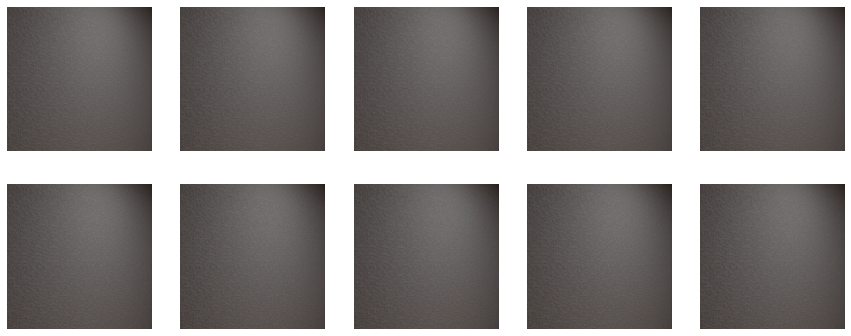

In [68]:
plt.figure(figsize=(15, 6))
for i, pic in enumerate(frames.cpu()[:,:,:,:3]):
    pic = pic.type(torch.int)
    plt.subplot(2,5,i+1)
    plt.imshow(pic)
    plt.axis('off')

    noisy_pic = pic + 255 * 0.01 * torch.randn_like(pic, dtype=torch.float)
    noisy_pic = noisy_pic.type(torch.int)
    plt.subplot(2,5,i+6)
    plt.imshow(noisy_pic)
    plt.axis('off')


In [27]:
from my_utils.data.dataset import build_dataset

build_dataset()

10 classes in total: {'Jump', 'Hip Hop Dancing', 'Flair', 'Standing', 'Waving', 'Clapping', 'Mma Kick', 'Jumping Jacks', 'Sweep Fall', 'Rumba Dancing'}


100%|███████████████████████████████████████████| 1155/1155 [01:00<00:00, 19.15it/s]


In [17]:
T = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((128, 64)),
        # transforms.Normalize(mean, std)
    # transforms.ColorJitter(brightness=.1, hue=.1)
])

In [21]:
dataset = MyDataset(
    ROOT='/mnt/cfs/wangyh/blender/blank_wall/datasets/random',
    reduce_mode='W',
    transform=T
)
loader = DataLoader(dataset, batch_size=32, shuffle=False)
len(loader.dataset)
# print(unseen_loader.dataset[0][0].shape)

['Clapping', 'Flair', 'Hip Hop Dancing', 'Jump', 'Jumping Jacks', 'Mma Kick', 'Rumba Dancing', 'Standing', 'Sweep Fall', 'Waving']


1120

In [22]:
dataset[0][0]

tensor([[[ 1.1108e-02,  3.0640e-02,  1.1108e-02,  ...,  4.2358e-02,
          -4.5166e-03,  5.7983e-02],
         [ 1.3367e-02,  4.0710e-02, -1.7883e-02,  ...,  4.0710e-02,
           9.4604e-03,  5.6335e-02],
         [ 4.4800e-02,  7.2144e-02, -1.7700e-02,  ...,  1.3550e-02,
           1.8311e-03, -7.6294e-02],
         ...,
         [ 9.2712e-02,  6.1462e-02,  1.0681e-02,  ...,  1.2396e-01,
           1.8494e-02, -4.0100e-02],
         [ 1.9830e-01,  1.5533e-01,  6.5491e-02,  ...,  1.7096e-01,
           2.6428e-02, -3.2166e-02],
         [ 1.3837e-01,  9.9304e-02,  9.5398e-02,  ...,  9.9304e-02,
           7.1960e-02, -6.0852e-02]],

        [[ 2.9297e-02,  4.1016e-02,  3.3203e-02,  ...,  2.9297e-02,
          -4.1016e-02,  3.7109e-02],
         [ 3.1921e-02,  5.9265e-02,  1.2390e-02,  ...,  8.2703e-02,
           2.4109e-02,  2.4109e-02],
         [ 5.7434e-02,  1.0559e-02, -5.0659e-03,  ...,  2.6184e-02,
          -2.4597e-02, -5.5847e-02],
         ...,
         [ 1.4471e-01,  7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

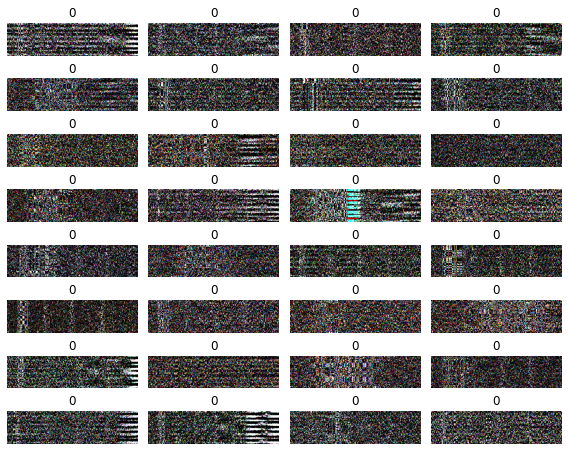

In [25]:
grid_vis(loader, row_num=8, multiply=20)

In [23]:
next(model.parameters()).device.index

1

In [21]:
from my_utils import models

model = models.NLOS_Conv().to(device)
model.load_state_dict(torch.load('/home/wangyh/01-Projects/01-NLOS/tb_logs/test_runs/2022_05_02_11_35_22/weights/100.0_2022_05_02_11_39_15.pt')['model_paras'])

<All keys matched successfully>

In [46]:
from my_utils.utils import check_accuracy

model.eval()
check_accuracy(model, unseen_loader)

Test accuracy is : 20.00%	Infer time: 0.478778600692749


In [69]:
inputs, labels = next(iter(unseen_loader))
print(inputs.shape)
print(labels)

torch.Size([40, 3, 128, 64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4])


In [70]:
model.eval()
scores = model(inputs.to(device))
preds = scores.argmax(dim=1)
print(preds)

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:1')
